# Helper functions

In [11]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import rosbag2_py

from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

from sensor_msgs.msg import JointState

plt.rcParams.update(
    {"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": ["Helvetica"]}
)


def get_rosbag_options(path, serialization_format="cdr"):
    storage_options = rosbag2_py.StorageOptions(uri=path, storage_id="sqlite3")

    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format=serialization_format,
        output_serialization_format=serialization_format,
    )

    return storage_options, converter_options


def read_jointstate_from_rosbag(storage_options, converter_options, topic, motor_num):
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)
    storage_filter = rosbag2_py.StorageFilter(topics=[topic])
    reader.set_filter(storage_filter)

    timestamps = []
    position = []
    velocity = []

    while reader.has_next():
        (topic, data, t) = reader.read_next()
        msg = deserialize_message(data, JointState)

        t = t * 1e-9

        timestamps.append(t)
        if msg.position:
            position.append(msg.position[motor_num])
        if msg.velocity:
            velocity.append(msg.velocity[motor_num])

    return timestamps, position, velocity


def trim_data(data, start_time, end_time):
    trimmed_data = [[], []]
    for t, d in zip(data[0], data[1]):
        if t < start_time:
            continue
        elif t > end_time:
            break
        else:
            trimmed_data[0].append(t)
            trimmed_data[1].append(d)

    return trimmed_data


def normalize_time(time_vector, start_time):
    return [t - start_time for t in time_vector]


def plot_motor_response_cmd(motor_response, label):
    fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 10 / 2), dpi=600)
    fig.tight_layout()

    axs.plot(motor_response[0], motor_response[1])

    axs.set_xlabel("Time [s]")
    axs.set_ylabel(label)
    axs.grid()


def motor_vel_from_bag_to_csv(
    motor_name: str, bag_path: str, rosbag_duration_to_read: float, rosbag_start_time: float = 0.0
):
    if motor_name == 'right':
        motor_num = 1
    else:
        motor_num = 0

    motor_response_vel = [[], []]

    storage_options, converter_options = get_rosbag_options(bag_path)
    motor_response_vel[0], _, motor_response_vel[1] = read_jointstate_from_rosbag(
        storage_options, converter_options, "/nono/joint_states", motor_num
    )

    start_time = motor_response_vel[0][0]
    trimmed_start = motor_response_vel[0][0] + rosbag_start_time
    trimmed_end = trimmed_start + rosbag_duration_to_read
    motor_response_vel = trim_data(motor_response_vel, trimmed_start, trimmed_end)
    motor_response_vel[0] = normalize_time(motor_response_vel[0], start_time)

    np.savetxt(f"csv/{motor_name}_ang_vel.csv", motor_response_vel, delimiter=", ", fmt='% s')

    return motor_response_vel


# Read joint states data

[INFO] [1687694983.104669778] [rosbag2_storage]: Opened database 'rosbag/vel_enc_dt_based_method/vel_enc_dt_based_method.db3' for READ_ONLY.


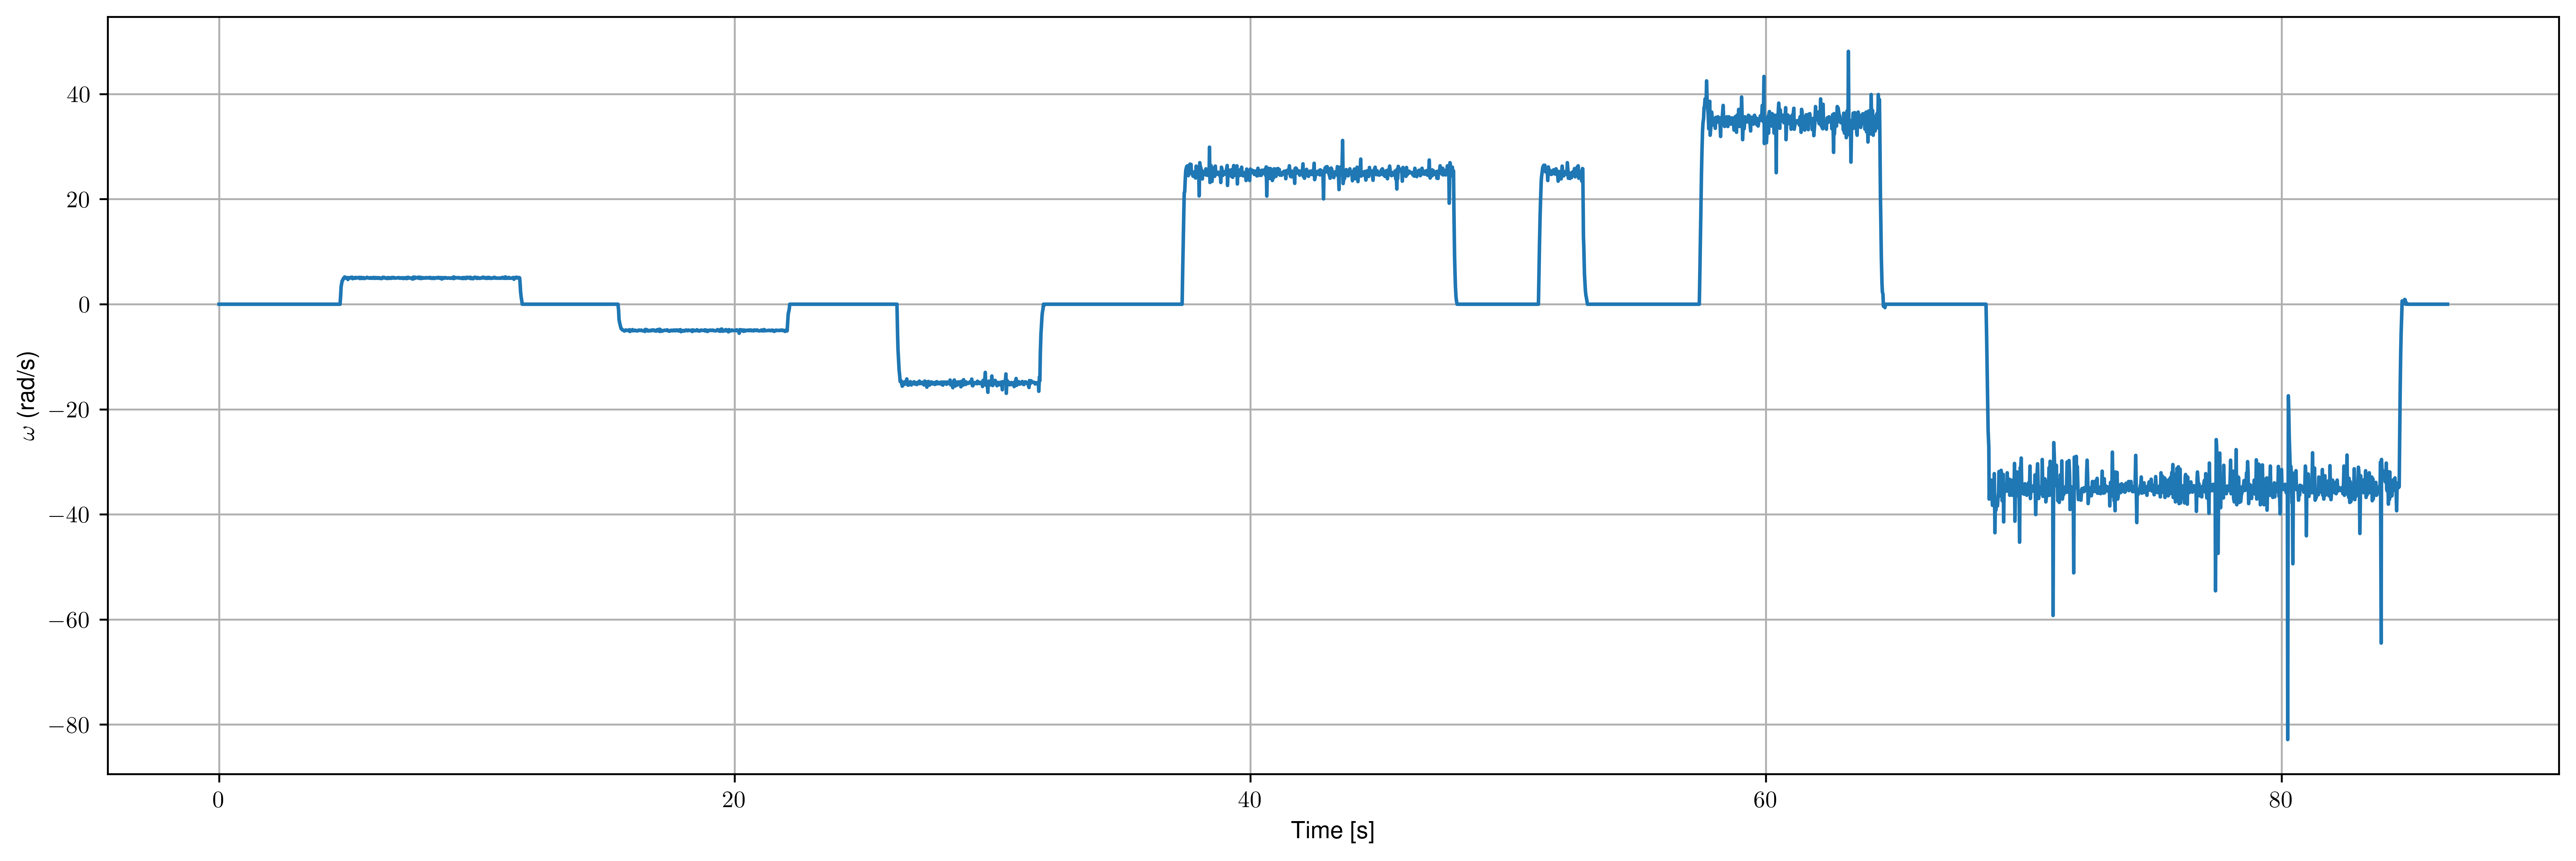

In [12]:
rosbag_duration_to_read = 90.0
rosbag_start_time = 0.0
bag_path = "rosbag/vel_enc_dt_based_method/vel_enc_dt_based_method.db3"
motor_name = 'right'

motor_response_vel = motor_vel_from_bag_to_csv(motor_name, bag_path, rosbag_duration_to_read)

plot_motor_response_cmd(motor_response_vel, "$\omega$ (rad/s)")